In [1]:
def general_conv2d(inputconv, o_d=64, f_h=7, f_w=7, s_h=1, s_w=1, stddev=0.02, padding="VALID", name="conv2d", do_norm=True, do_relu=True, relufactor=0):
    with tf.variable_scope(name):
        conv = tf.contrib.layers.conv2d(inputconv, o_d, f_w, s_w, padding, activation_fn=None, weights_initializer=tf.truncated_normal_initializer(stddev=stddev),biases_initializer=tf.constant_initializer(0.0))
        conv = tf.nn.relu(conv,"relu")
        return conv

def general_deconv2d(inputconv, outshape, o_d=64, f_h=7, f_w=7, s_h=1, s_w=1, stddev=0.02, padding="VALID", name="deconv2d", do_norm=True, do_relu=True, relufactor=0):
    with tf.variable_scope(name):
        conv = tf.contrib.layers.conv2d_transpose(inputconv, o_d, [f_h, f_w], [s_h, s_w], padding, activation_fn=None, weights_initializer=tf.truncated_normal_initializer(stddev=stddev),biases_initializer=tf.constant_initializer(0.0))
        conv = tf.nn.relu(conv,"relu")
        return conv
    
def build_resnet_block(inputres, dim, name="resnet"):
    with tf.variable_scope(name):
        out_res = tf.pad(inputres, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
        out_res = general_conv2d(out_res, dim, 3, 3, 1, 1, 0.02, "VALID","c1")
        out_res = tf.pad(out_res, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
        out_res = general_conv2d(out_res, dim, 3, 3, 1, 1, 0.02, "VALID","c2",do_relu=False)
        return tf.nn.relu(out_res + inputres)
    

In [2]:
def generator(inputgen, name="generator"):
    with tf.variable_scope(name):
        f = 7
        ks = 3
        ngf = 64

        pad_input = tf.pad(inputgen,[[0, 0], [ks, ks], [ks, ks], [0, 0]], "REFLECT")
        o_c1 = general_conv2d(pad_input, ngf, f, f, 1, 1, 0.02,name="c1")
        o_c2 = general_conv2d(o_c1, ngf*2, ks, ks, 2, 2, 0.02,"SAME","c2")
        o_c3 = general_conv2d(o_c2, ngf*4, ks, ks, 2, 2, 0.02,"SAME","c3")

        o_r1 = build_resnet_block(o_c3, ngf*4, "r1")
        o_r2 = build_resnet_block(o_r1, ngf*4, "r2")
        o_r3 = build_resnet_block(o_r2, ngf*4, "r3")
        o_r4 = build_resnet_block(o_r3, ngf*4, "r4")
        o_r5 = build_resnet_block(o_r4, ngf*4, "r5")
        o_r6 = build_resnet_block(o_r5, ngf*4, "r6")

        o_c4 = general_deconv2d(o_r6, [1,64,64,ngf*2], ngf*2, ks, ks, 2, 2, 0.02,"SAME","c4")
        o_c5 = general_deconv2d(o_c4, [1,128,128,ngf], ngf, ks, ks, 2, 2, 0.02,"SAME","c5")
        o_c5_pad = tf.pad(o_c5,[[0, 0], [ks, ks], [ks, ks], [0, 0]], "REFLECT")
        o_c6 = general_conv2d(o_c5_pad, 3, f, f, 1, 1, 0.02,"VALID","c6",do_relu=False)

        # Adding the tanh layer

        out_gen = tf.nn.tanh(o_c6,"t1")


        return out_gen

In [3]:
def discriminator(inputdisc, name="discriminator"):
    with tf.variable_scope(name):
        f = 4
        ndf = 64

        o_c1 = general_conv2d(inputdisc, ndf, f, f, 2, 2, 0.02, "SAME", "c1", do_norm=False, relufactor=0.2)
        o_c2 = general_conv2d(o_c1, ndf*2, f, f, 2, 2, 0.02, "SAME", "c2", relufactor=0.2)
        o_c3 = general_conv2d(o_c2, ndf*4, f, f, 2, 2, 0.02, "SAME", "c3", relufactor=0.2)
        o_c4 = general_conv2d(o_c3, ndf*8, f, f, 1, 1, 0.02, "SAME", "c4",relufactor=0.2)
        o_c5 = general_conv2d(o_c4, 1, f, f, 1, 1, 0.02, "SAME", "c5",do_norm=False,do_relu=False)

        return o_c5

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt 
import numpy as np

train_a_files = tf.train.match_filenames_once("/Users/zjucx/Documents/Github/GAN/dataset/input/monet2photo/trainA/*.jpg")    
train_b_files = tf.train.match_filenames_once("/Users/zjucx/Documents/Github/GAN/dataset/input/monet2photo/trainB/*.jpg")    


train_a_queue = tf.train.string_input_producer(train_a_files)
train_b_queue = tf.train.string_input_producer(train_b_files)


image_reader = tf.WholeFileReader()
_, image_a = image_reader.read(train_a_queue)
_, image_b = image_reader.read(train_b_queue)

image_A = tf.subtract(tf.div(tf.image.resize_images(tf.image.decode_jpeg(image_a),[256,256]),127.5),1)
image_B = tf.subtract(tf.div(tf.image.resize_images(tf.image.decode_jpeg(image_b),[256,256]),127.5),1)


input_A = tf.placeholder(tf.float32, [1, 256, 256, 3], name="input_A")
input_B = tf.placeholder(tf.float32, [1, 256, 256, 3], name="input_B")

with tf.variable_scope("Model") as scope:
    gena = generator(input_B, name="g_A")
    genb = generator(input_A, name="g_B")
    dica = discriminator(input_A, name="d_A")
    dicb = discriminator(input_B, name="d_B")
    
    scope.reuse_variables()
    
    cyca = generator(genb, name="g_A")
    cycb = generator(gena, name="g_B")
    dic_gana = discriminator(gena, name="d_A")
    dic_ganb = discriminator(genb, name="d_B")

d_loss_a = (tf.reduce_mean(tf.squared_difference(gena, 1)) + tf.reduce_mean(tf.square(dic_gana)))/2
d_loss_b = (tf.reduce_mean(tf.squared_difference(genb, 1)) + tf.reduce_mean(tf.square(dic_ganb)))/2

cyc_loss = tf.reduce_mean(tf.abs(input_A-cyca)) + tf.reduce_mean(tf.abs(input_B-cycb))

g_loss_a = cyc_loss*10 + tf.reduce_mean(tf.squared_difference(dic_gana, 1))
g_loss_b = cyc_loss*10 + tf.reduce_mean(tf.squared_difference(dic_ganb, 1))

optimizer = tf.train.AdamOptimizer(0.0002, beta1=0.5)

model_vars = tf.trainable_variables()
d_A_vars = [var for var in model_vars if 'd_A' in var.name]
g_A_vars = [var for var in model_vars if 'g_A' in var.name]
d_B_vars = [var for var in model_vars if 'd_B' in var.name]
g_B_vars = [var for var in model_vars if 'g_B' in var.name]

d_A_trainer = optimizer.minimize(d_loss_a, var_list=d_A_vars)
d_B_trainer = optimizer.minimize(d_loss_b, var_list=d_B_vars)
g_A_trainer = optimizer.minimize(g_loss_a, var_list=g_A_vars)
g_B_trainer = optimizer.minimize(g_loss_b, var_list=g_B_vars)

for var in d_A_vars: print(var.name)


Model/d_A/c1/Conv/weights:0
Model/d_A/c1/Conv/biases:0
Model/d_A/c2/Conv/weights:0
Model/d_A/c2/Conv/biases:0
Model/d_A/c3/Conv/weights:0
Model/d_A/c3/Conv/biases:0
Model/d_A/c4/Conv/weights:0
Model/d_A/c4/Conv/biases:0
Model/d_A/c5/Conv/weights:0
Model/d_A/c5/Conv/biases:0


num0 g_A_trainer:9.995347 d_B_trainer:0.499494 g_B_trainer:9.991033 d_A_trainer0.495026


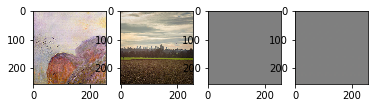

num1 g_A_trainer:9.990760 d_B_trainer:0.497621 g_B_trainer:9.962864 d_A_trainer0.466118
num2 g_A_trainer:9.923907 d_B_trainer:0.469727 g_B_trainer:8.805333 d_A_trainer0.217203


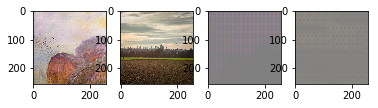

num3 g_A_trainer:12.174022 d_B_trainer:0.223522 g_B_trainer:9.578974 d_A_trainer0.485474
num4 g_A_trainer:11.846072 d_B_trainer:0.075194 g_B_trainer:10.515724 d_A_trainer0.499212


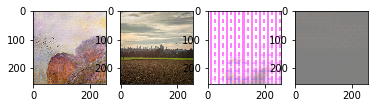

num5 g_A_trainer:9.981985 d_B_trainer:0.190127 g_B_trainer:9.988381 d_A_trainer0.499642
num6 g_A_trainer:9.989987 d_B_trainer:0.290577 g_B_trainer:9.989727 d_A_trainer0.499609


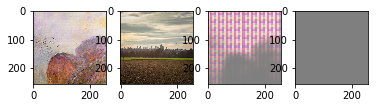

num7 g_A_trainer:9.989918 d_B_trainer:0.342116 g_B_trainer:9.987721 d_A_trainer0.499311
INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Enqueue operation was cancelled
	 [[Node: input_producer_1/input_producer_1_EnqueueMany = QueueEnqueueManyV2[Tcomponents=[DT_STRING], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](input_producer_1, input_producer_1/RandomShuffle)]]


KeyboardInterrupt: 

In [5]:
with tf.Session() as sess:
    sess.run([tf.global_variables_initializer(), tf.local_variables_initializer()])
    
    # Loading images into the tensors
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    imga = sess.run(image_A).reshape((1, 256, 256, 3))
    imgb = sess.run(image_B).reshape((1, 256, 256, 3))
    for epoch in range(0,101):
        
        # Optimizing the G_A network
        _, a, imggena, imggenb = sess.run([g_A_trainer, g_loss_a, genb, gena],feed_dict={input_A:imga, input_B:imgb})
        _, b = sess.run([d_B_trainer, d_loss_b],feed_dict={input_A:imga, input_B:imgb})
        _, c = sess.run([g_B_trainer, g_loss_b],feed_dict={input_A:imga, input_B:imgb})
        _, d = sess.run([d_A_trainer, d_loss_a],feed_dict={input_A:imga, input_B:imgb})

        print("num%d g_A_trainer:%f d_B_trainer:%f g_B_trainer:%f d_A_trainer%f"%(epoch, a, b, c, d))
        if epoch%2 == 0:
            plt.subplot(141); plt.imshow(((imga.reshape((256, 256, 3))+1)*127.5).astype(np.uint8))
            plt.subplot(142); plt.imshow(((imgb.reshape((256, 256, 3))+1)*127.5).astype(np.uint8))
            plt.subplot(143); plt.imshow(((imggena.reshape((256, 256, 3))+1)*127.5).astype(np.uint8))
            plt.subplot(144); plt.imshow(((imggenb.reshape((256, 256, 3))+1)*127.5).astype(np.uint8))
            plt.show()
    coord.request_stop()
    coord.join(threads)